In [3]:
import os
import random
import numpy as np
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

COLOR_MAP = ListedColormap([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], name='custom_discrete', N=4)
BOUNDARIES = [0, 1, 2, 3, 4]
NORM = BoundaryNorm(BOUNDARIES, COLOR_MAP.N)

MODALITIES = ['flair', 't1', 't2', 't1ce', 'seg']

DATA_DIR = "/root/workspace/BraTS_Solution/data/brats21/BraTS2021_Training_Data"

In [ ]:

class MultiModalityLoader():
    def __init__(self, data_dir, modalities, transforms=None, merge=False):
        self.data_dir = data_dir
        self.modals = modalities
        self.transforms = transforms
        self.merge = merge
        
    def get_patient_ids(self):
        return [d.split('_')[-1] for d in os.listdir(self.data_dir) if d.startswith('BraTS2021')]
        
    def get_id_paths(self, patient_id):
        paths_dict = {}
        paths_dict[patient_id] = {}
        for modal in self.modals:
            path = os.path.join(self.data_dir, f"BraTS2021_{patient_id}", f"BraTS2021_{patient_id}_{modal}.nii.gz")
            paths_dict[patient_id][modal] = path
        return paths_dict
    
    def get_all_paths(self, length=100):
        all_paths_dict = {}
        for patient_id in self.get_patient_ids()[:length] if length else self.get_patient_ids():
            all_paths_dict[patient_id] = self.get_id_paths(patient_id)
        return all_paths_dict
    
    def get_data(self, patient_id):
        data = {}
        data[patient_id] = {}
        for modality in self.modals:
            path = os.path.join(self.data_dir, f"BraTS2021_{patient_id}", f"BraTS2021_{patient_id}_{modality}.nii.gz")
            data[patient_id][modality] = nib.load(path).get_fdata().transpose((2, 0, 1))
        return data

    def get_data_merged(self, patient_id):
        data = self.get_data(patient_id)
        data_merged = {}
        data_merged[patient_id] = {}
        modals = [modal for modal in self.modals if modal!='seg']
        data_merged[patient_id]['image'] = np.stack([data[patient_id][modal] for modal in modals], axis=0)
        data_merged[patient_id]['label'] = data[patient_id]['seg']
        return data_merged
    
    def get_transformed_data(self, patient_id):
        data = self.get_data_merged(patient_id)
        image = data[patient_id]['image'] # [4, 155, 240, 240]
        label = data[patient_id]['label'] # [155, 240, 240]
        data_transformed = {}
        data_transformed[patient_id] = {}
        image_trans, label_trans = self.transforms(image, label)
        data_transformed[patient_id]['image'] = image_trans
        data_transformed[patient_id]['label'] = label_trans
        return data_transformed
    
    def __getitem__(self, patient_id):
        """
        if merge:
            return data_dict:[patient_id][image/label]
        else:
            return data_dict:[patient_id][modal]
        """
        if self.merge:
            if self.transforms is not None:
                return self.get_transformed_data(patient_id)
            else:
                return self.get_data_merged(patient_id)
        else:
            return self.get_data(patient_id)
    
    def __len__(self):
        return len(self.get_patient_ids())
    
    def __iter__(self):
        for patient_id in self.get_patient_ids():
            yield self[patient_id]
        

In [5]:
class MultiModalityPloter:
    def __init__(self, data_dict, cmap='bone'):
        self.data_dict = data_dict
        self.cmap = cmap
        
    def get_slices(self, axis, slice_idx=100, cmap='bone'):
        """获取指定轴和切片的图像数据"""
        slice_dict = {}
        for patient_id, id_data in self.data_dict.items():
            slice_dict[patient_id] = {}
            for modal, data in id_data.items():
                slice_dict[patient_id][modal] = self.get_slice_from_axis(data, axis, slice_idx)
        return slice_dict

    def get_slice_from_axis(self, data, axis, index):
    # print(data.shape)
        slices = [slice(None)] * len(data.shape)
        if len(data.shape) == 4:
            slices[axis+1] = index
        else:
            slices[axis] = index    
        slice_index = data[tuple(slices)]
        # print(slice_index.shape)            # [slice(None, None, None), slice(None, None, None), slice(None, None, None)]             # [slice(None, None, None), index, slice(None, None, None)]
        return slice_index

    @staticmethod
    def _plot_data(slice_dict, axs_size=3, cmap='bone'):
        for id, id_slices in slice_dict.items():
            figsize= (axs_size*len(id_slices), axs_size)
            fig, axs = plt.subplots(1, len(id_slices), figsize=figsize)
            fig.text(0.1, 0.5, f'ID: {id}', va='center', ha='right', rotation=90, fontsize=8)
            for i, (modal, slice) in enumerate(id_slices.items()):
                if modal == 'seg':
                    modal = 'GroudTruth'
                    axs[i].imshow(slice, cmap=COLOR_MAP, norm=NORM, alpha=1)
                    # axs[i].set_title(f'{modal}')
                    axs[i].axis('off')
                else:
                    axs[i].imshow(slice, cmap=cmap)
                    # axs[i].set_title(f'{modal}')
                    axs[i].axis('off')
            plt.show()

    @staticmethod
    def _plot_data_merged(slice_dict, axs_size=3, cmap='bone'):
        figsize= (axs_size*5, axs_size)
        fig, axs = plt.subplots(1, 5, figsize=figsize)
        for id, id_slices in slice_dict.items():
            for modal, slices in id_slices.items():
                if modal == 'image':
                    axs[0].imshow(slices[0], cmap=cmap)
                    axs[0].axis('off')
                    axs[1].imshow(slices[1], cmap=cmap)
                    axs[1].axis('off')
                    axs[2].imshow(slices[2], cmap=cmap)
                    axs[2].axis('off')
                    axs[3].imshow(slices[3], cmap=cmap)
                    axs[3].axis('off')
                elif modal == 'label':
                    axs[4].imshow(slices, cmap=COLOR_MAP, norm=NORM, alpha=1)
                    axs[4].axis('off')
            plt.show()

loader = MultiModalityLoader(DATA_DIR, MODALITIES, merge=True)


# loader['00018']
# ploter = MultiModalityPloter(loader['00018'])
# slices_dict = ploter.get_slices(0, 100)
# ploter._plot_data_merged(slices_dict, axs_size=5)




In [116]:
import sys
sys.path.append("..")

from src.datasets.transforms import *

trans = Compose([
    # CenterCrop3D((144, 144, 144)),
    RandomFlip3D(),
    RandomCrop3D((128, 128, 128)),
    FrontGroundNormalize(),
    RandomNoise3D(mean=0.0, std=(0, 0.1)),
])

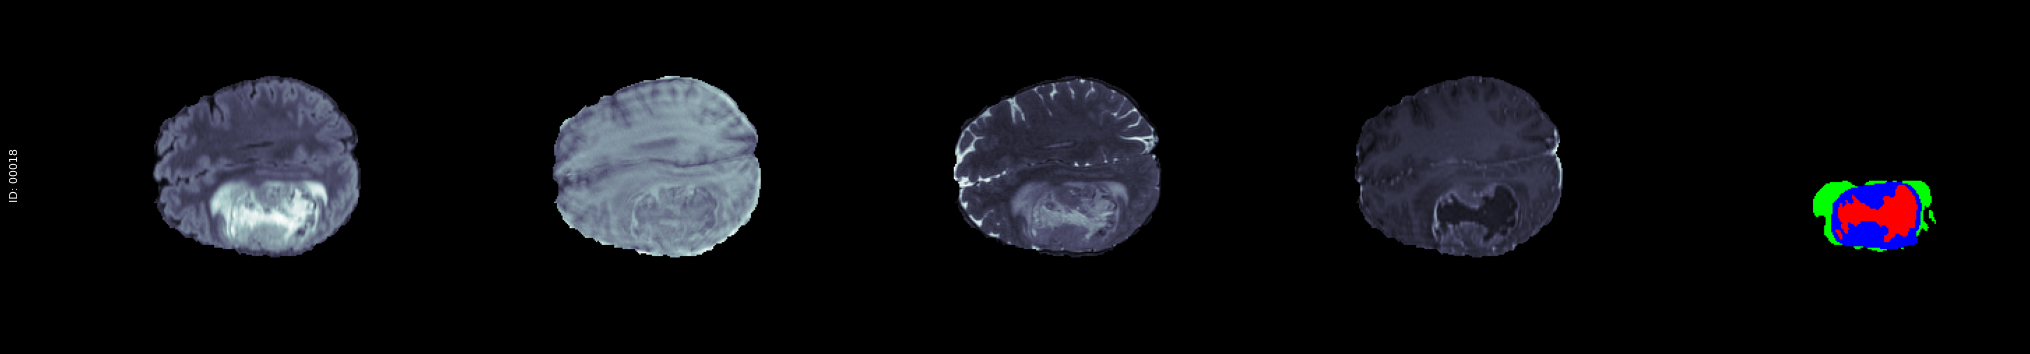

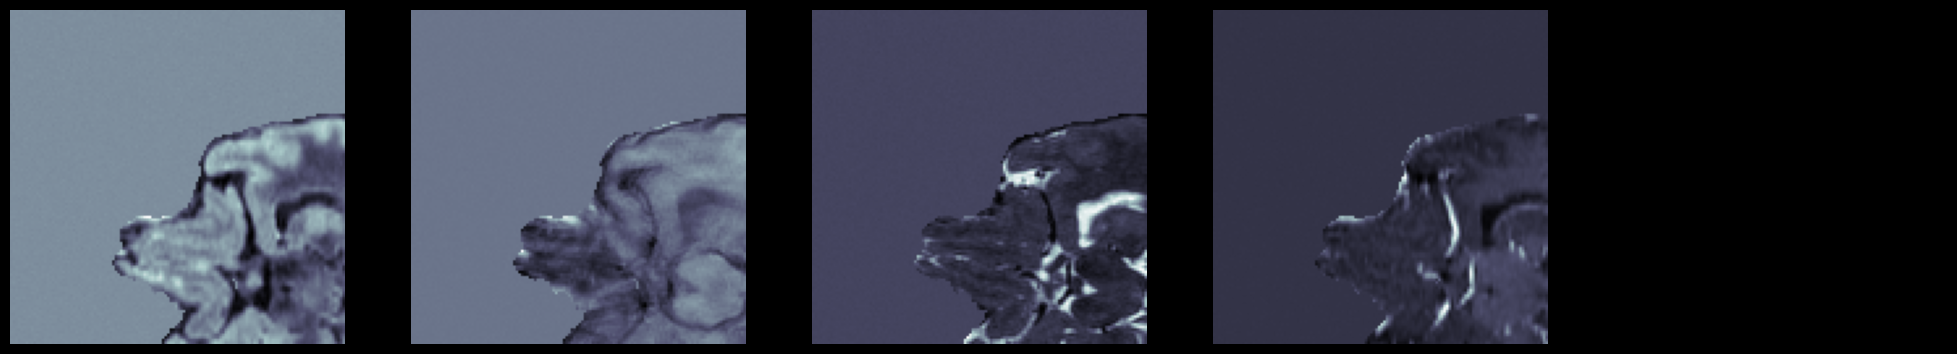

In [117]:
loader = MultiModalityLoader(DATA_DIR, MODALITIES, merge=False)
trans_loader = MultiModalityLoader(DATA_DIR, MODALITIES, merge=True, transforms=trans)

ploter = MultiModalityPloter(loader['00018'])
trans_ploter = MultiModalityPloter(trans_loader['00018'])

slices_dict = ploter.get_slices(0, 100)
trans_slices = trans_ploter.get_slices(0, 100)

ploter._plot_data(slices_dict, axs_size=5)
ploter._plot_data_merged(trans_slices, axs_size=5)

# data_shape = [155, 240, 240]

# for s in range(data_shape[0]):
#     slice_dict = ploter.get_slices(2, s)
#     ploter._plot_data(slice_dict, axs_size=3, cmap='bone')

In [105]:
# for data in loader:
#     print(data)

In [7]:
# for data in loader:
#     print(data)

In [8]:
def get_IntensityRange(self, patient_id):
    data = self[patient_id]
    intensity_ranges = {}
    for modal, img in data.items():
        intensity_ranges[modal] = {'modal': modal, 'min': img.min(), 'max': img.max()}
        
    df = pd.DataFrame(intensity_ranges).T
    df['patient_id'] = patient_id
    df = df[['patient_id', 'modal', 'min', 'max']]        
    return df

def get_all_IntensityRange(self, length=100, save_flag=True, save_path=None):
    all_intensity_ranges = []
    for patient_id in self.get_patient_ids()[:length] if length else self.get_patient_ids():
        df = self.get_IntensityRange(patient_id)
        all_intensity_ranges.append(df)
    df = pd.concat(all_intensity_ranges, ignore_index=True)
    save_path = save_path if (save_path is not None) else os.path.join('./', 'intensity_ranges')
    if save_flag:
        os.makedirs(save_path, exist_ok=True)
        df.to_csv(os.path.join(save_path, 'all_intensity_ranges.csv'), index=False)
    return df